# Pengumpulan Data

In [2]:
import openeo
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [3]:
warnings.filterwarnings("ignore")

In [ ]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

## Kriteria Data yang Diambil

Data yang digunakan merupakan **data NO₂ (Nitrogen Dioksida)** dari satelit **Sentinel-5P (S5P)** melalui layanan **Copernicus OpenEO**.

### Wilayah Pengambilan Data
Data diambil untuk wilayah **Kabupaten Bojonegoro**, dengan batas koordinat sebagai berikut:

| Titik | Longitude | Latitude |
|:------|:-----------|:----------|
| 1 | 111.84013944486253 | -7.112176997696622 |
| 2 | 111.84013944486253 | -7.201964283327371 |
| 3 | 111.93244545164555 | -7.201964283327371 |
| 4 | 111.93244545164555 | -7.112176997696622 |
| 5 | 111.84013944486253 | -7.112176997696622 |

> Area ini membentuk sebuah poligon yang mewakili area observasi di wilayah Bojonegoro.

### entang Waktu Pengambilan Data
Data diambil dari **1 Juni 2025 hingga 19 Oktober 2025**.
---

Dengan langkah-langkah ini, diperoleh data rata-rata harian konsentrasi **NO₂** di wilayah Bojonegoro selama periode Juni–Oktober 2025.


In [ ]:
aoi_geojson = {
    "type": "Polygon",
    "coordinates": [
        [
            [111.84013944486253, -7.112176997696622],
            [111.84013944486253, -7.201964283327371],
            [111.93244545164555, -7.201964283327371],
            [111.93244545164555, -7.112176997696622],
            [111.84013944486253, -7.112176997696622]
        ]
    ]
}


s5post = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2025-06-01", "2025-10-19"],
    spatial_extent={"west": 111.84013944486253, "south": -7.201964283327371, "east": 111.93244545164555, "north": -7.112176997696622},
    bands=["NO2"],
)

# 4. Mask nilai negatif (data invalid)
def mask_invalid(x):
    return x < 0

s5p_masked = s5post.mask(s5post.apply(mask_invalid))

# 5. Agregasi temporal harian
daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

# 6. Agregasi spasial (rata-rata dalam AOI)
daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi_geojson, reducer="mean")

# 7. Jalankan batch job dan hasilkan file CSV
job = daily_mean_aoi.execute_batch(out_format="CSV")

# 8. Unduh hasil job
results = job.get_results()
results.download_files("no2_bojonegoro_post")

0:00:00 Job 'j-2510210402374f0ca6b808b8854aa2e7': send 'start'
0:00:13 Job 'j-2510210402374f0ca6b808b8854aa2e7': created (progress 0%)
0:00:19 Job 'j-2510210402374f0ca6b808b8854aa2e7': created (progress 0%)
0:00:25 Job 'j-2510210402374f0ca6b808b8854aa2e7': created (progress 0%)
0:00:34 Job 'j-2510210402374f0ca6b808b8854aa2e7': running (progress N/A)
0:00:44 Job 'j-2510210402374f0ca6b808b8854aa2e7': running (progress N/A)
0:00:56 Job 'j-2510210402374f0ca6b808b8854aa2e7': running (progress N/A)
0:01:13 Job 'j-2510210402374f0ca6b808b8854aa2e7': running (progress N/A)
0:01:32 Job 'j-2510210402374f0ca6b808b8854aa2e7': running (progress N/A)
0:01:57 Job 'j-2510210402374f0ca6b808b8854aa2e7': running (progress N/A)
0:02:27 Job 'j-2510210402374f0ca6b808b8854aa2e7': running (progress N/A)
0:03:05 Job 'j-2510210402374f0ca6b808b8854aa2e7': finished (progress 100%)


[WindowsPath('no2_bojonegoro_post/timeseries.csv'),
 WindowsPath('no2_bojonegoro_post/job-results.json')]

In [ ]:
blh = connection.load_collection(
    "ECMWF_ERA5_LAND_MONTHLY",
    temporal_extent=["2025-06-01", "2025-10-19"],
    spatial_extent={"west": 111.8401, "south": -7.2019, "east": 111.9324, "north": -7.1121},
    bands=["blh"]  # boundary layer height
)

daily_blh = blh.aggregate_temporal_period(period="day", reducer="mean")
daily_blh_aoi = daily_blh.aggregate_spatial(geometries=aoi_geojson, reducer="mean")

job_blh = daily_blh_aoi.execute_batch(out_format="CSV")
results_blh = job_blh.get_results()
results_blh.download_files("blh_bojonegoro_post")

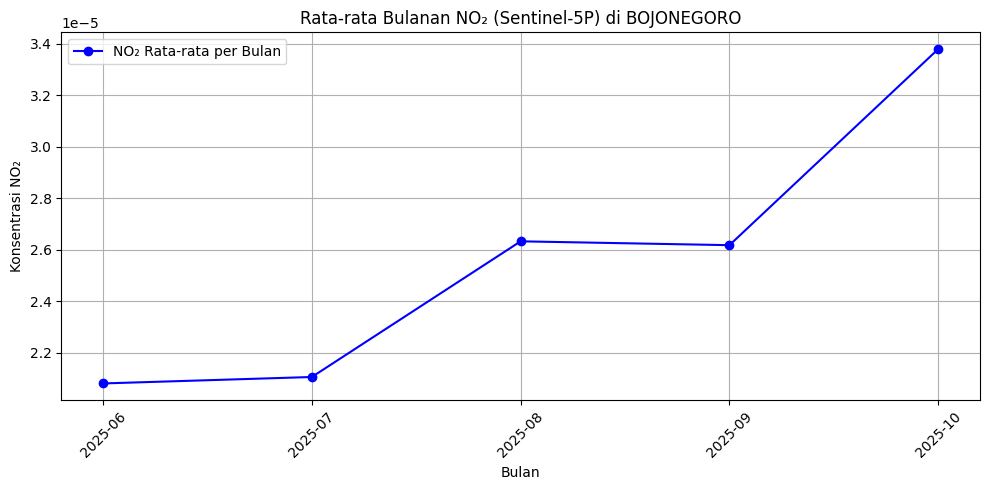

In [5]:
# Baca data
df = pd.read_csv("no2_bojonegoro_post/timeseries.csv")

df["date"] = pd.to_datetime(df["date"])

# 11. Buat kolom bulan (YYYY-MM)
df["month"] = df["date"].dt.to_period("M")

# 12. Hitung rata-rata NO2 per bulan
df_monthly = df.groupby("month", as_index=False)["NO2"].mean()

# 13. Visualisasi hasil
plt.figure(figsize=(10,5))
plt.plot(df_monthly["month"].astype(str), df_monthly["NO2"], marker="o", color="blue", label="NO₂ Rata-rata per Bulan")
plt.title("Rata-rata Bulanan NO₂ (Sentinel-5P) di BOJONEGORO")
plt.xlabel("Bulan")
plt.ylabel("Konsentrasi NO₂")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Data Dapat diunduh

Dataset: [Dataset NO2 di Bojonegoro](no2_bojonegoro_post/timeseries.csv)